In [1]:
# Community detection (Maja)
# Backbone detection

# Community Detection Analysis - Game of Thrones Dialogues
# Using Louvain Method for detecting character communities

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import community as community_louvain  # You may need to: pip install python-louvain
import seaborn as sns
from wordcloud import WordCloud

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
# 1. CREATE THE GRAPH (if you haven't already)
from basic_analysis import create_graph

all_dialogues, G = create_graph(path_name='data/dialogues.csv')

In [3]:
# 2. COMMUNITY DETECTION USING LOUVAIN METHOD

def detect_communities(G):
    """
    Detect communities using the Louvain method.
    Returns partition dictionary and modularity score.
    """
    # Convert to undirected for community detection
    G_undirected = G.to_undirected()
    
    # Apply Louvain method
    partition = community_louvain.best_partition(G_undirected, weight='weight')
    
    # Calculate modularity
    modularity = community_louvain.modularity(partition, G_undirected, weight='weight')
    
    print(f"Number of communities detected: {len(set(partition.values()))}")
    print(f"Modularity Q-score: {modularity:.4f}")
    print(f"(Higher modularity indicates stronger community structure, max = 1.0)\n")
    
    return partition, modularity

partition, modularity = detect_communities(G)

Number of communities detected: 8
Modularity Q-score: 0.5406
(Higher modularity indicates stronger community structure, max = 1.0)



In [4]:
# 3. ANALYZE COMMUNITY COMPOSITION

def analyze_communities(partition, G):
    """
    Analyze and display information about each community.
    """
    # Count members per community
    community_counts = Counter(partition.values())
    num_communities = len(community_counts)
    
    print("="*70)
    print("COMMUNITY COMPOSITION ANALYSIS")
    print("="*70)
    
    # Sort communities by size
    sorted_communities = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    
    for comm_id, size in sorted_communities:
        members = [node for node, comm in partition.items() if comm == comm_id]
        
        print(f"\n{'='*70}")
        print(f"COMMUNITY {comm_id} ({size} members):")
        print(f"{'='*70}")
        
        # List all members
        print("Members:")
        for i, member in enumerate(sorted(members), 1):
            degree = G.degree(member, weight='weight')
            print(f"  {i:2d}. {member:<25} (weighted degree: {degree:.2f})")
        
        # Calculate internal vs external edges
        internal_edges = 0
        external_edges = 0
        
        for node in members:
            for neighbor in G.neighbors(node):
                if partition[neighbor] == comm_id:
                    internal_edges += 1
                else:
                    external_edges += 1
        
        print(f"\nCommunity Statistics:")
        print(f"  Internal connections: {internal_edges}")
        print(f"  External connections: {external_edges}")
        if internal_edges + external_edges > 0:
            cohesion = internal_edges / (internal_edges + external_edges)
            print(f"  Cohesion ratio: {cohesion:.3f}")
    
    return sorted_communities

community_info = analyze_communities(partition, G)

COMMUNITY COMPOSITION ANALYSIS

COMMUNITY 7 (19 members):
Members:
   1. Arya Stark                (weighted degree: 0.58)
   2. Barristan Selmy           (weighted degree: 0.07)
   3. Beth Cassel               (weighted degree: 0.01)
   4. Cersei Lannister          (weighted degree: 0.55)
   5. Ilyn Payne                (weighted degree: 0.00)
   6. Jaime Lannister           (weighted degree: 0.36)
   7. Jeyne Poole               (weighted degree: 0.01)
   8. Joffrey Baratheon         (weighted degree: 0.36)
   9. Mordane                   (weighted degree: 0.11)
  10. Mycah                     (weighted degree: 0.04)
  11. Myrcella Baratheon        (weighted degree: 0.03)
  12. Nymeria                   (weighted degree: 0.01)
  13. Sandor Clegane            (weighted degree: 0.11)
  14. Sansa Stark               (weighted degree: 0.57)
  15. Tommen Baratheon          (weighted degree: 0.03)
  16. Unknown (A man)           (weighted degree: 0.00)
  17. Unknown (A second man)    (weig

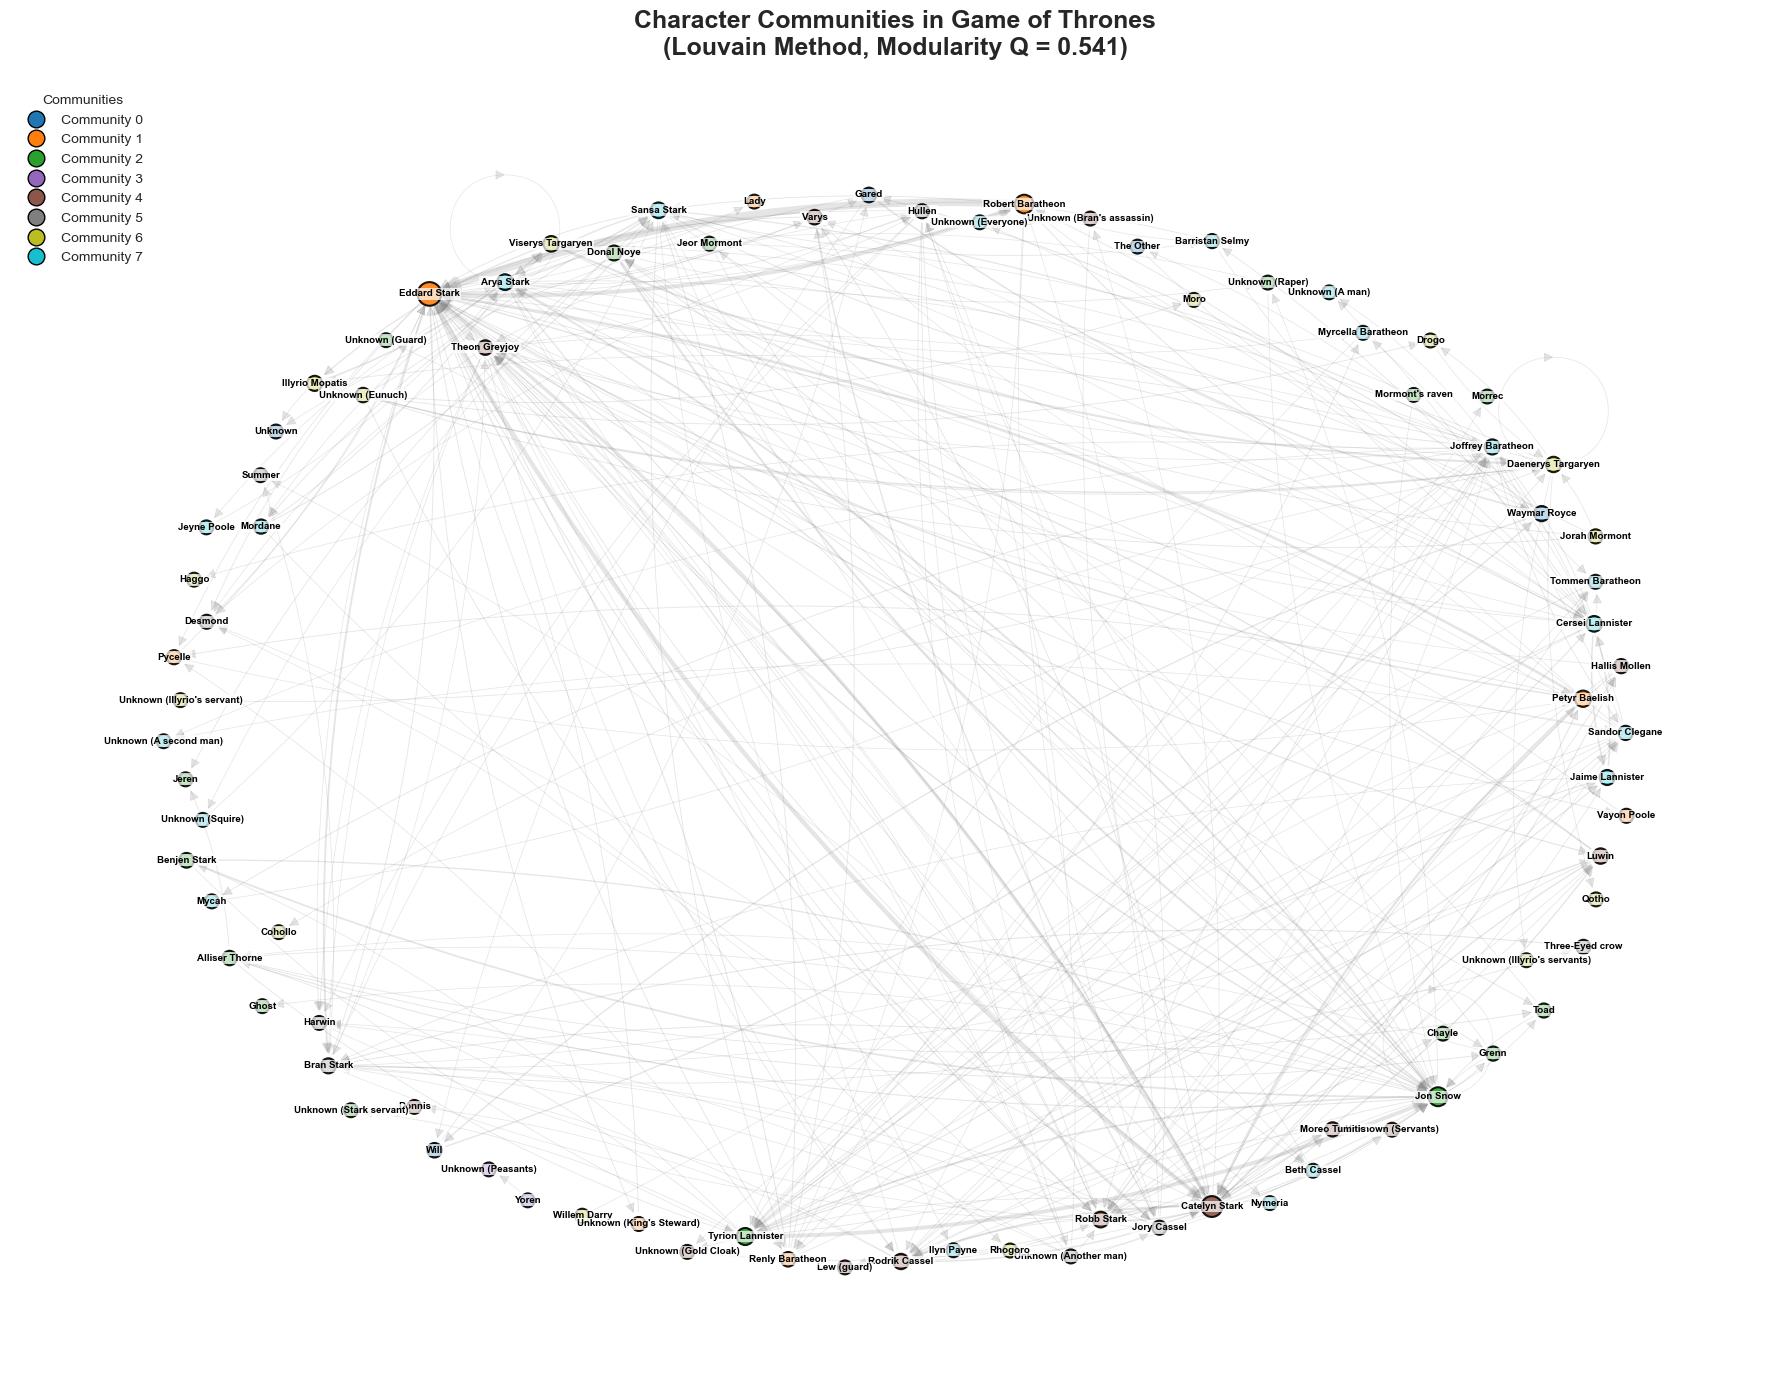

In [5]:
# 4. VISUALIZE COMMUNITIES

def visualize_communities(G, partition, figsize=(18, 14)):
    """
    Visualize the network with nodes colored by community.
    """
    plt.figure(figsize=figsize)
    
    # Create layout
    pos = nx.spring_layout(G, k=3, iterations=100, seed=42)
    
    # Get unique communities and assign colors
    communities = set(partition.values())
    colors = plt.cm.tab10(np.linspace(0, 1, len(communities)))
    community_colors = {comm: colors[i] for i, comm in enumerate(sorted(communities))}
    
    # Node colors based on community
    node_colors = [community_colors[partition[node]] for node in G.nodes()]
    
    # Node sizes based on degree
    degrees = dict(G.degree(weight='weight'))
    node_sizes = [degrees[n] * 50 + 100 for n in G.nodes()]
    
    # Draw edges
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    normalized_weights = [(w / max_weight) * 5 + 0.5 for w in weights]
    
    nx.draw_networkx_edges(
        G, pos,
        width=normalized_weights,
        alpha=0.2,
        edge_color='gray',
        arrows=True,
        arrowsize=15,
        connectionstyle='arc3,rad=0.1'
    )
    
    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Draw labels
    nx.draw_networkx_labels(
        G, pos,
        font_size=7,
        font_family='sans-serif',
        font_weight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
    )
    
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=community_colors[comm], 
                                  markersize=12, label=f'Community {comm}',
                                  markeredgecolor='black', markeredgewidth=1)
                      for comm in sorted(communities)]
    
    plt.legend(handles=legend_elements, loc='upper left', fontsize=10, 
              framealpha=0.9, title='Communities')
    
    plt.title(f"Character Communities in Game of Thrones\n"
             f"(Louvain Method, Modularity Q = {modularity:.3f})", 
             fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_communities(G, partition)

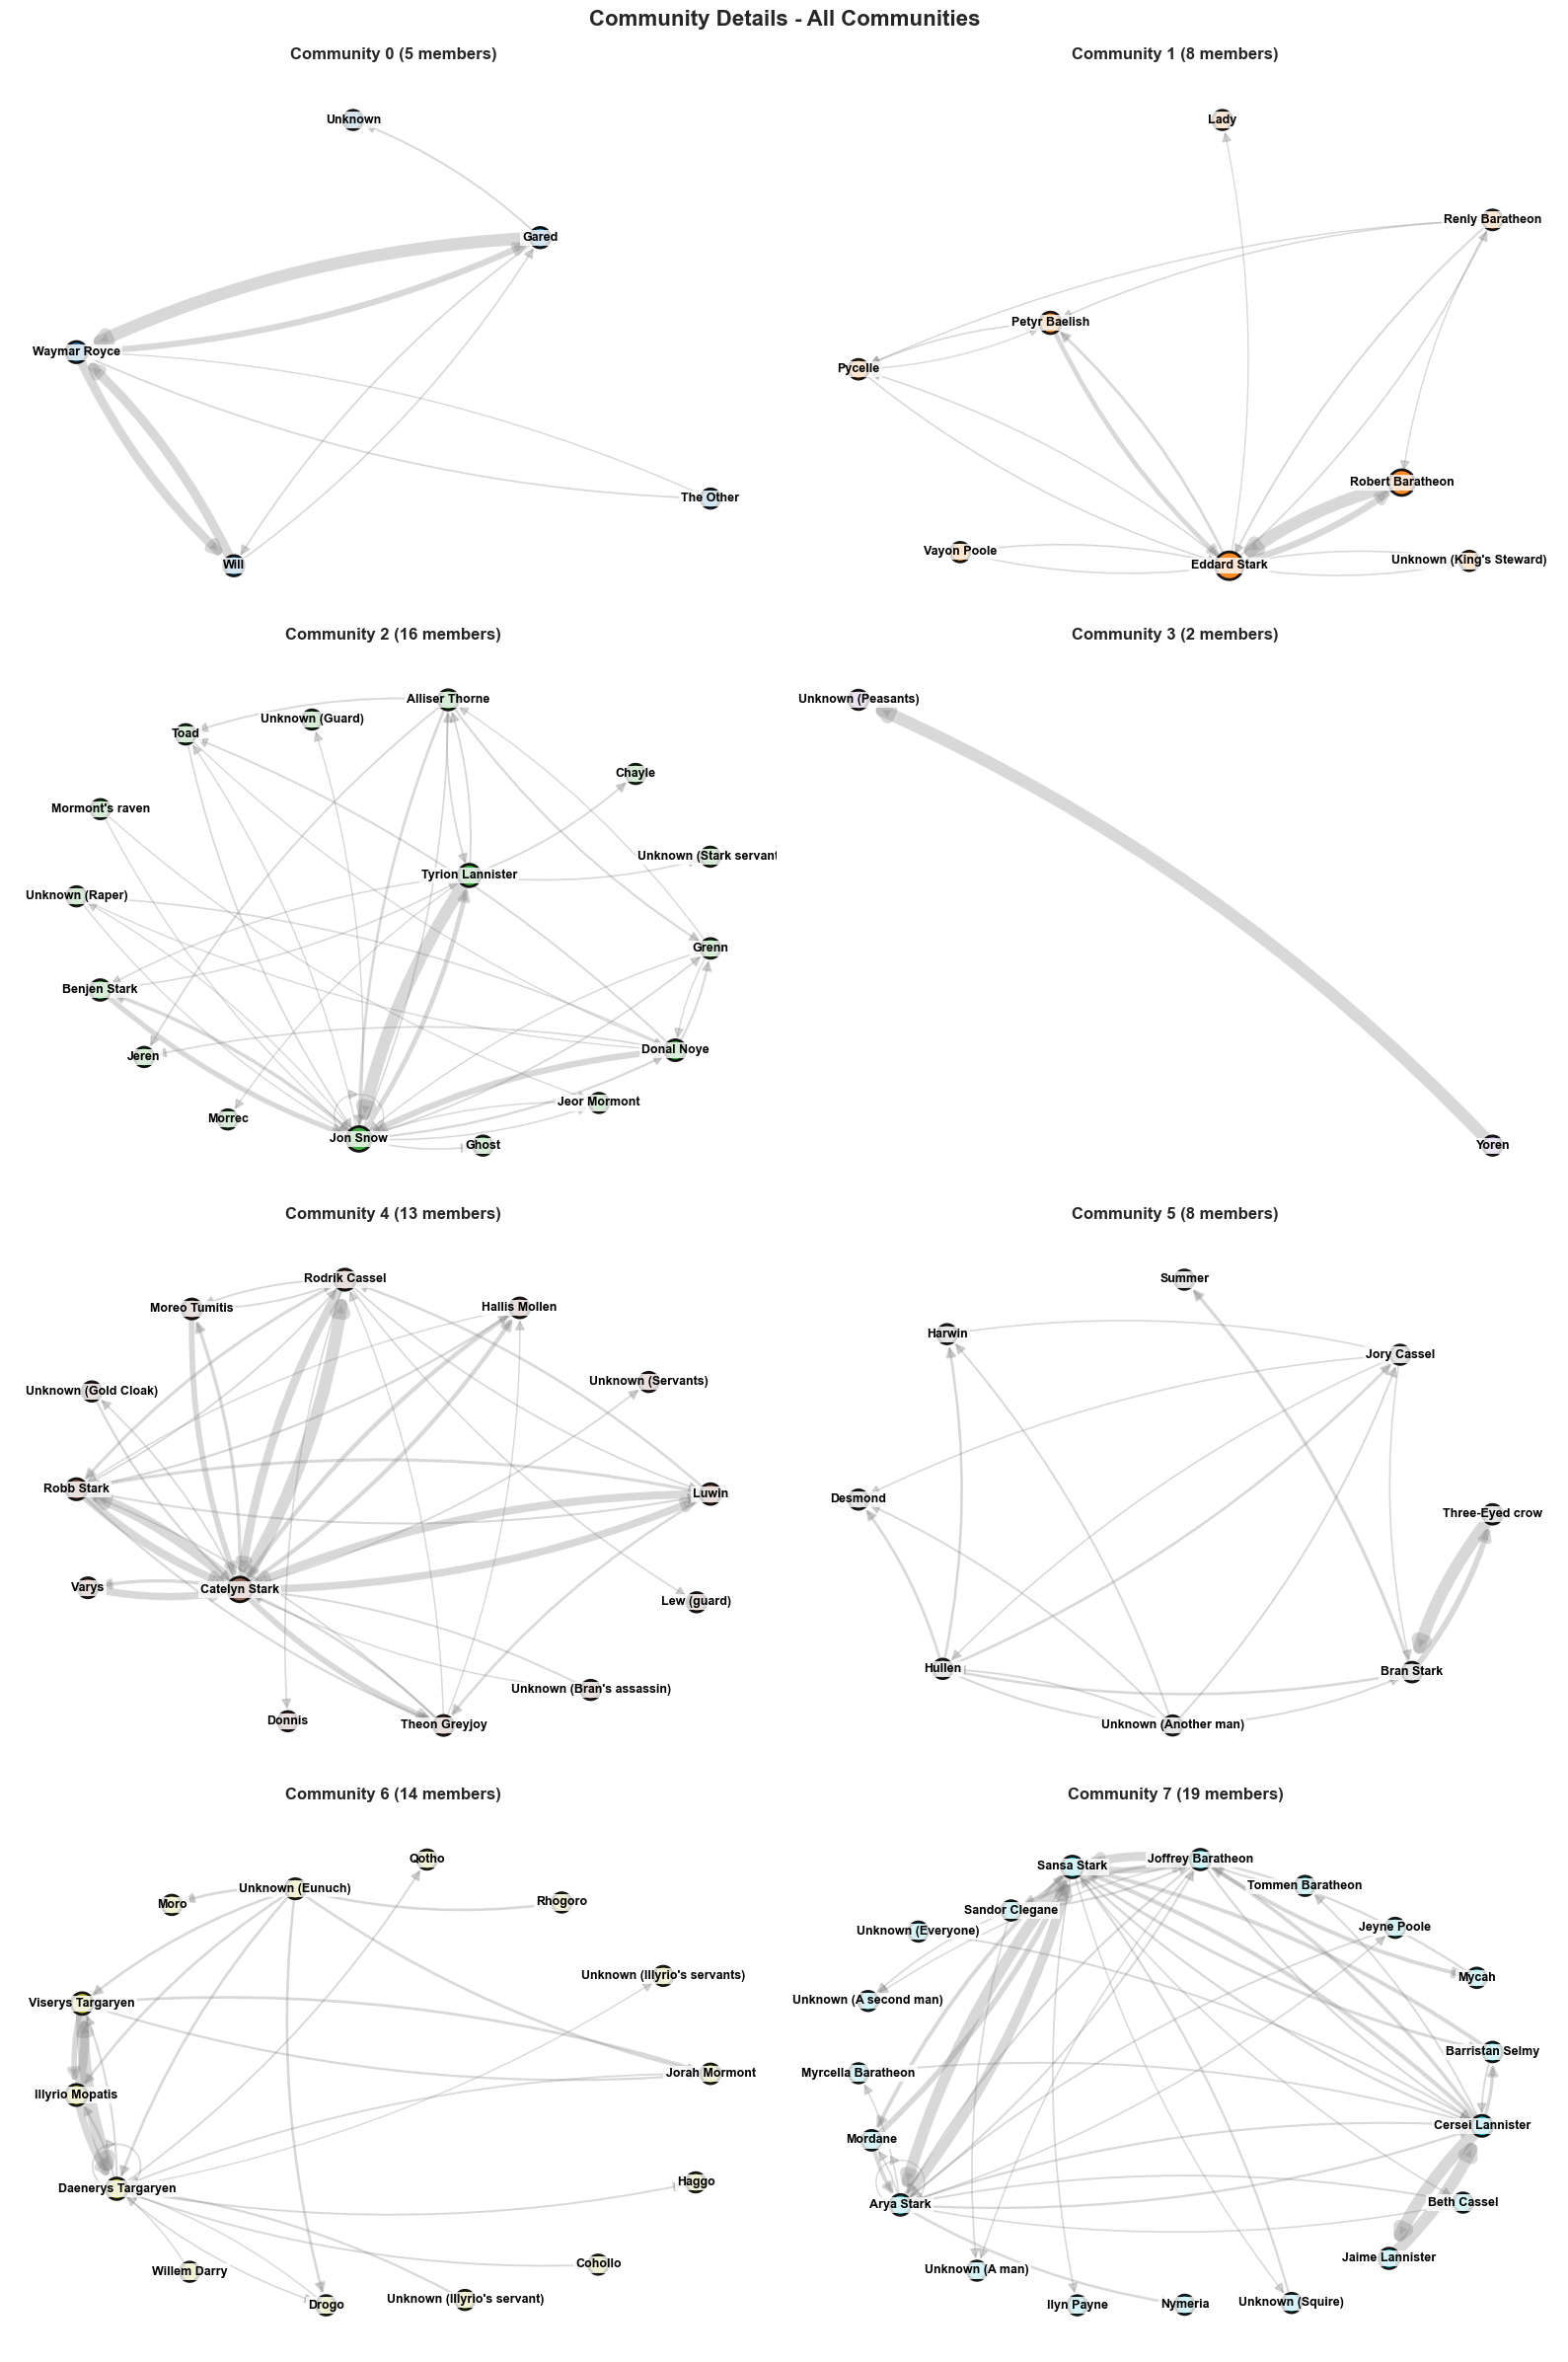

In [15]:
# 4.a VISUALIZE EACH COMMUNITY SEPARATELY IN A GRID (2 columns)

def visualize_communities_separately_grid(G, partition, n_cols=2, figsize=(16, 6)):
    """
    Create separate visualization for each community in a grid layout.
    """
    communities = sorted(set(partition.values()))
    n_communities = len(communities)
    n_rows = (n_communities + n_cols - 1) // n_cols
    
    # Adjust figure size based on number of rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    
    if n_communities == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(communities)))
    
    for i, comm_id in enumerate(communities):
        ax = axes[i]
        
        # Get nodes in this community
        comm_nodes = [node for node, comm in partition.items() if comm == comm_id]
        
        # Create subgraph for this community
        subgraph = G.subgraph(comm_nodes)
        
        if len(subgraph.nodes()) == 0:
            ax.text(0.5, 0.5, f'Community {comm_id}\n(Empty)', 
                   ha='center', va='center', fontsize=12)
            ax.axis('off')
            continue
        
        # Layout for this community
        pos = nx.spring_layout(subgraph, k=2, iterations=100, seed=42)
        
        # Node sizes based on degree
        degrees = dict(subgraph.degree(weight='weight'))
        node_sizes = [degrees[n] * 100 + 200 for n in subgraph.nodes()]
        
        # Edge weights
        if len(subgraph.edges()) > 0:
            weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
            max_weight = max(weights) if weights else 1
            normalized_weights = [(w / max_weight) * 8 + 1 for w in weights]
        else:
            normalized_weights = []
        
        # Draw edges
        nx.draw_networkx_edges(
            subgraph, pos,
            width=normalized_weights,
            alpha=0.3,
            edge_color='gray',
            arrows=True,
            arrowsize=15,
            connectionstyle='arc3,rad=0.1',
            ax=ax
        )
        
        # Draw nodes
        nx.draw_networkx_nodes(
            subgraph, pos,
            node_size=node_sizes,
            node_color=[colors[i]],
            alpha=0.9,
            edgecolors='black',
            linewidths=2,
            ax=ax
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            subgraph, pos,
            font_size=9,
            font_family='sans-serif',
            font_weight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=1.5),
            ax=ax
        )
        
        ax.set_title(f'Community {comm_id} ({len(comm_nodes)} members)', 
                    fontsize=12, fontweight='bold', pad=10)
        ax.axis('off')
    
    # Hide empty subplots
    for j in range(n_communities, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Community Details - All Communities', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

visualize_communities_separately_grid(G, partition, n_cols=2)

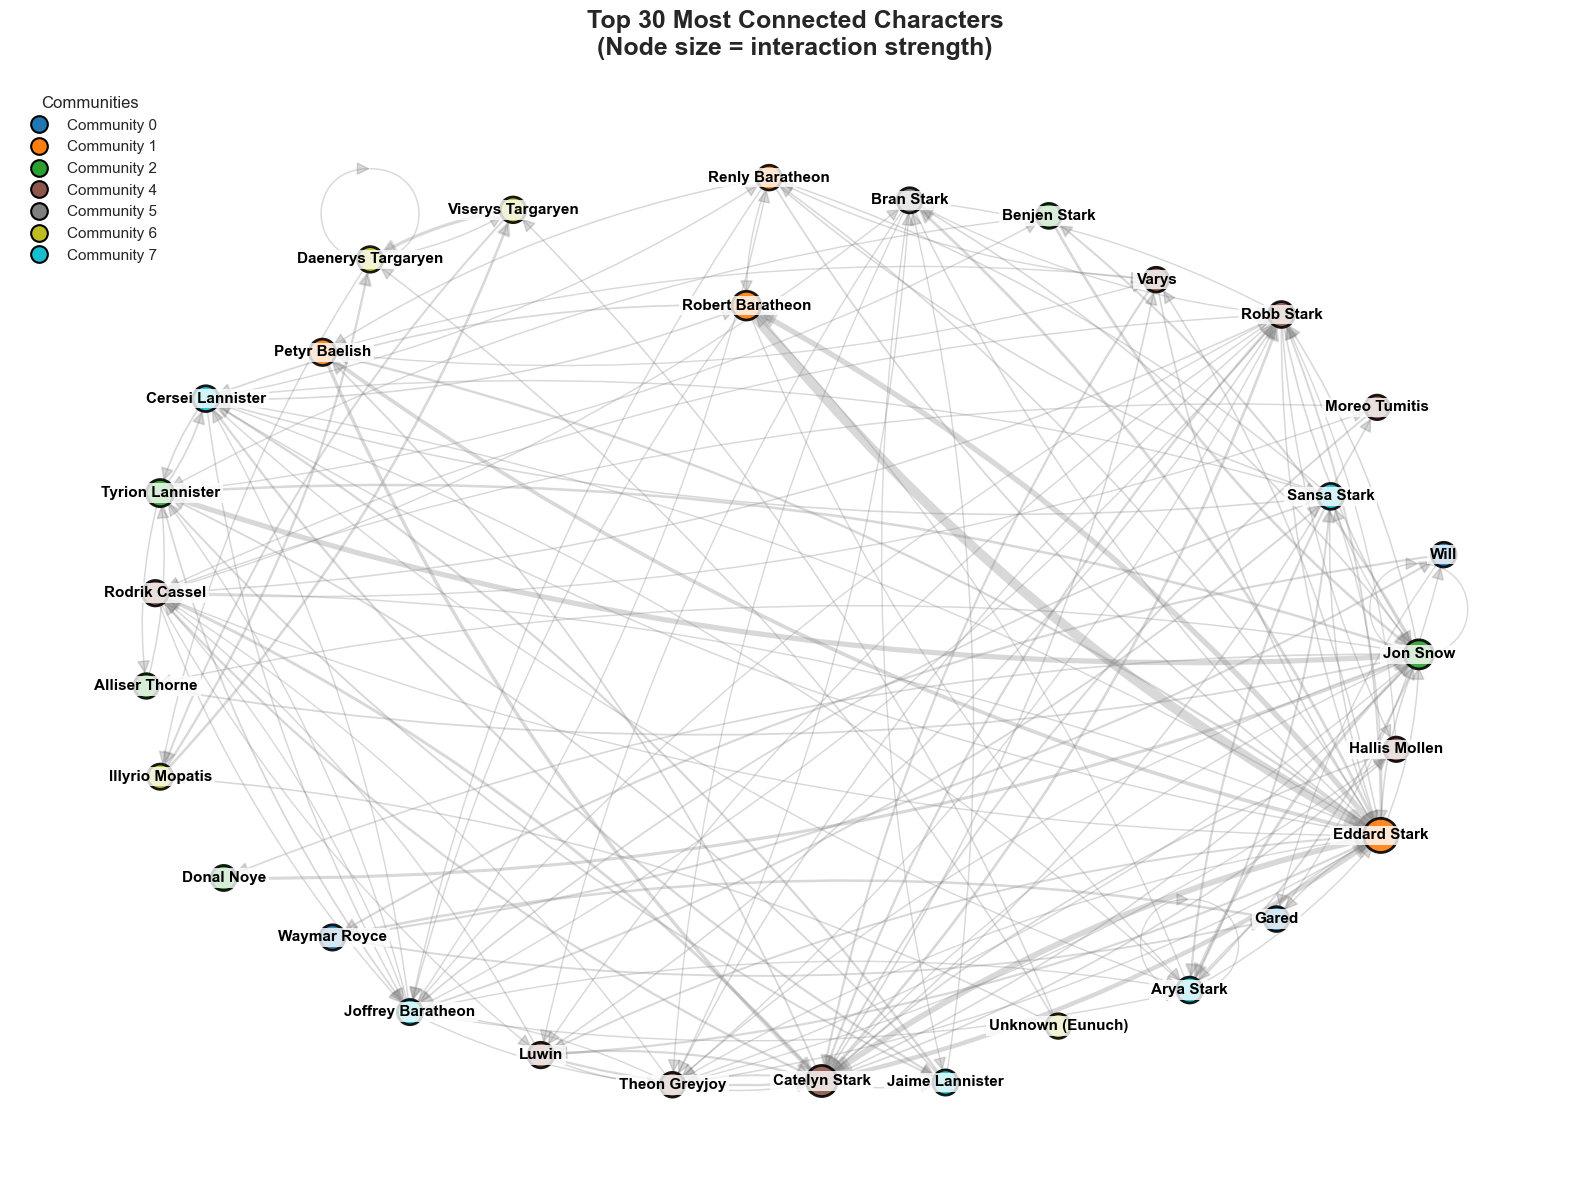

In [13]:
# 4.b VISUALIZE ONLY MAJOR CHARACTERS (Top N by Degree)

def visualize_major_characters(G, partition, top_n=30, figsize=(16, 12)):
    """
    Visualize only the top N most connected characters for clarity.
    """
    # Get top nodes by weighted degree
    degrees = dict(G.degree(weight='weight'))
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = [node for node, degree in top_nodes]
    
    # Create subgraph with only top nodes
    subgraph = G.subgraph(top_node_names)
    
    plt.figure(figsize=figsize)
    
    # Create layout
    pos = nx.spring_layout(subgraph, k=3, iterations=100, seed=42)
    
    # Get unique communities in this subgraph
    communities_in_subgraph = set(partition[node] for node in subgraph.nodes())
    colors = plt.cm.tab10(np.linspace(0, 1, len(set(partition.values()))))
    community_colors = {comm: colors[i] for i, comm in enumerate(sorted(set(partition.values())))}
    
    # Node colors based on community
    node_colors = [community_colors[partition[node]] for node in subgraph.nodes()]
    
    # Node sizes based on degree
    node_sizes = [degrees[n] * 80 + 300 for n in subgraph.nodes()]
    
    # Draw edges
    if len(subgraph.edges()) > 0:
        weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
        max_weight = max(weights) if weights else 1
        normalized_weights = [(w / max_weight) * 6 + 1 for w in weights]
    else:
        normalized_weights = []
    
    nx.draw_networkx_edges(
        subgraph, pos,
        width=normalized_weights,
        alpha=0.3,
        edge_color='gray',
        arrows=True,
        arrowsize=20,
        connectionstyle='arc3,rad=0.1'
    )
    
    # Draw nodes
    nx.draw_networkx_nodes(
        subgraph, pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9,
        edgecolors='black',
        linewidths=2
    )
    
    # Draw labels with larger font
    nx.draw_networkx_labels(
        subgraph, pos,
        font_size=11,
        font_family='sans-serif',
        font_weight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=2)
    )
    
    # Create legend for communities that appear in this view
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=community_colors[comm], 
                                  markersize=12, label=f'Community {comm}',
                                  markeredgecolor='black', markeredgewidth=1.5)
                      for comm in sorted(communities_in_subgraph)]
    
    plt.legend(handles=legend_elements, loc='upper left', fontsize=11, 
              framealpha=0.9, title='Communities', title_fontsize=12)
    
    plt.title(f"Top {top_n} Most Connected Characters\n"
             f"(Node size = interaction strength)", 
             fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_major_characters(G, partition, top_n=30)

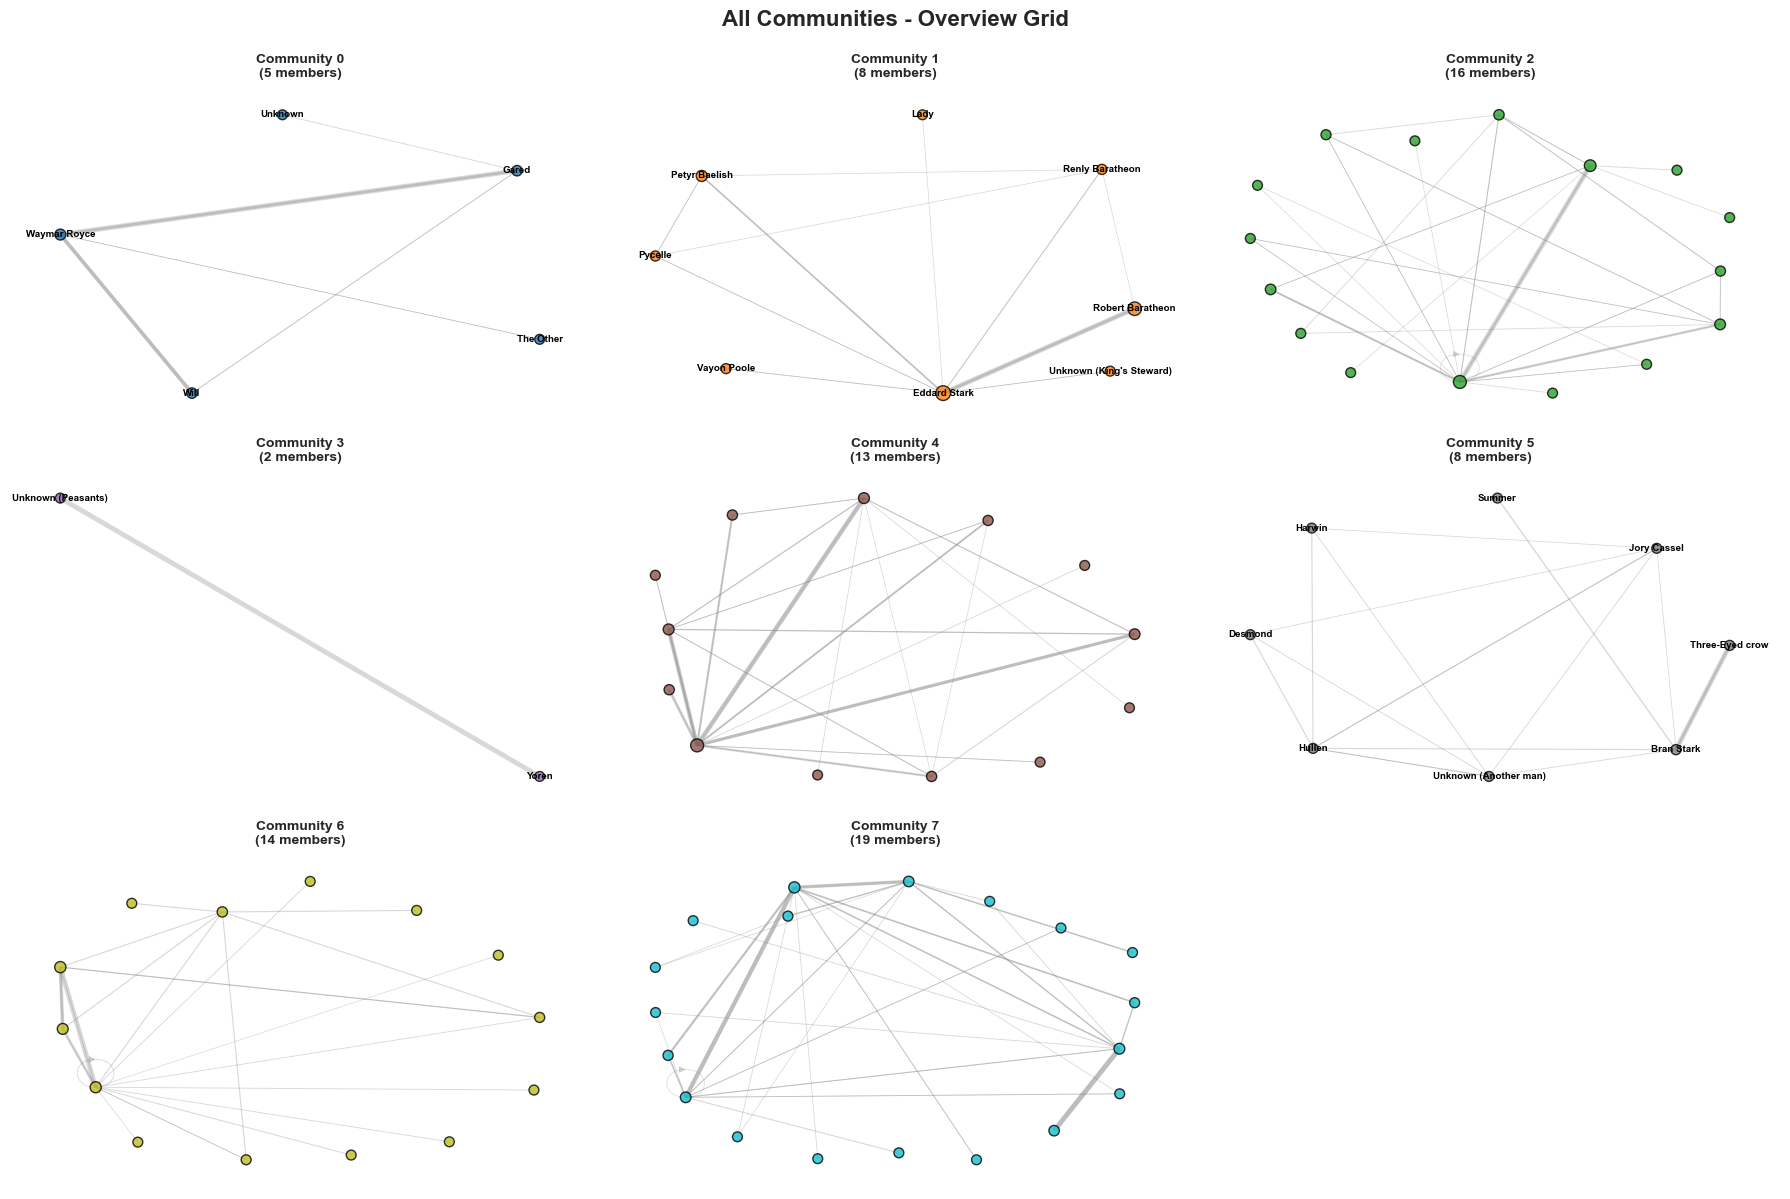

In [14]:
# 4.c COMMUNITY OVERVIEW GRID (Alternative Compact View)

def visualize_communities_grid(G, partition, n_cols=3, figsize=(18, 12)):
    """
    Show all communities in a grid layout, one subplot per community.
    """
    communities = sorted(set(partition.values()))
    n_communities = len(communities)
    n_rows = (n_communities + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    if n_communities == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(communities)))
    
    for i, comm_id in enumerate(communities):
        ax = axes[i]
        
        # Get nodes in this community
        comm_nodes = [node for node, comm in partition.items() if comm == comm_id]
        subgraph = G.subgraph(comm_nodes)
        
        if len(subgraph.nodes()) == 0:
            ax.text(0.5, 0.5, f'Community {comm_id}\n(Empty)', 
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
            continue
        
        # Layout
        pos = nx.spring_layout(subgraph, k=1.5, iterations=50, seed=42)
        
        # Node sizes
        degrees = dict(subgraph.degree(weight='weight'))
        if degrees:
            node_sizes = [degrees[n] * 30 + 50 for n in subgraph.nodes()]
        else:
            node_sizes = [100] * len(subgraph.nodes())
        
        # Edge weights
        if len(subgraph.edges()) > 0:
            weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
            max_weight = max(weights) if weights else 1
            normalized_weights = [(w / max_weight) * 3 + 0.5 for w in weights]
        else:
            normalized_weights = []
        
        # Draw
        nx.draw_networkx_edges(subgraph, pos, width=normalized_weights, 
                              alpha=0.3, edge_color='gray', arrows=False, ax=ax)
        nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, 
                              node_color=[colors[i]], alpha=0.8, 
                              edgecolors='black', linewidths=1, ax=ax)
        
        # Labels (only for communities with few members)
        if len(comm_nodes) <= 10:
            nx.draw_networkx_labels(subgraph, pos, font_size=7, 
                                   font_weight='bold', ax=ax)
        
        ax.set_title(f'Community {comm_id}\n({len(comm_nodes)} members)', 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
    
    # Hide empty subplots
    for j in range(n_communities, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('All Communities - Overview Grid', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

visualize_communities_grid(G, partition, n_cols=3)

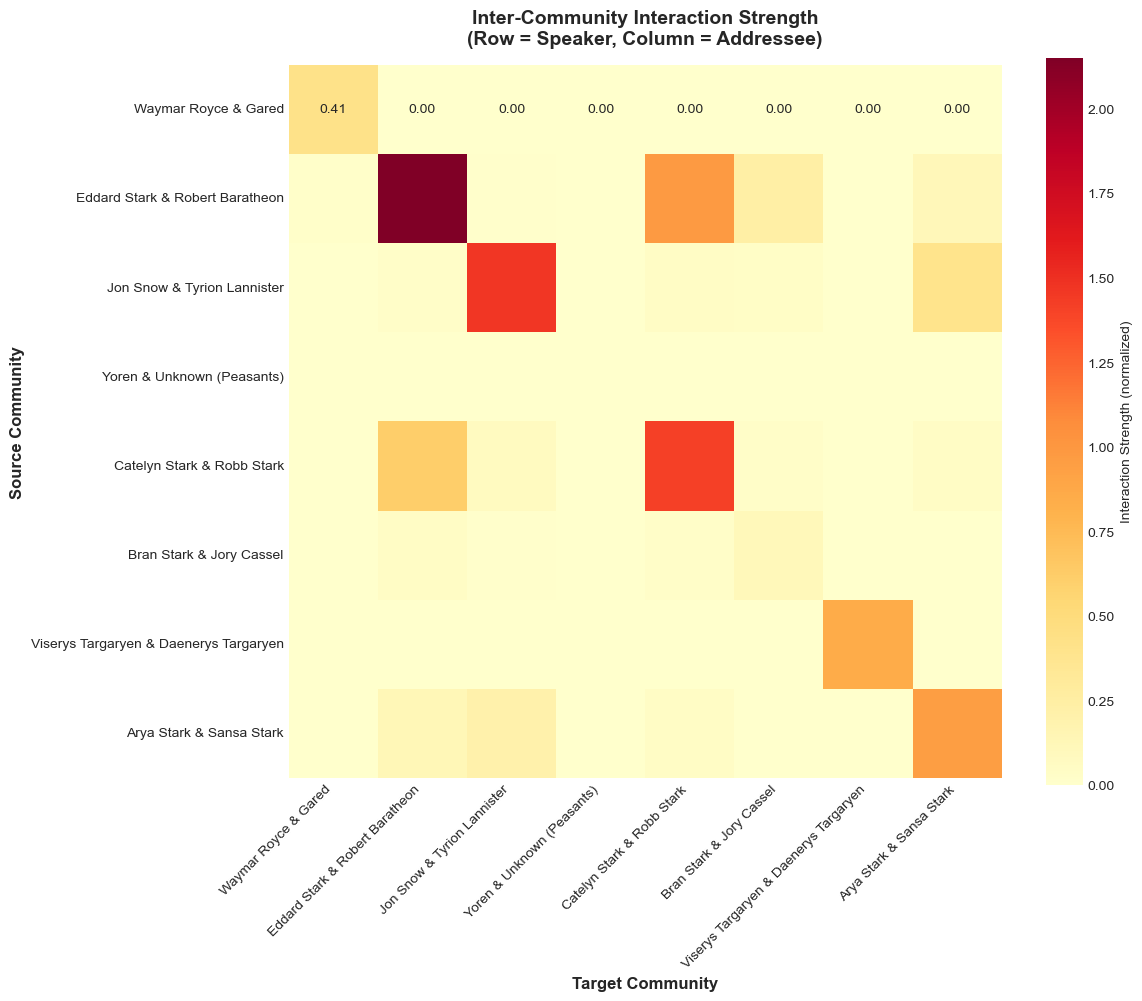


COMMUNITY INTERACTION INTERPRETATION

Diagonal values (high) = Strong internal communication
Off-diagonal values (high) = Strong cross-community interaction

Key interactions:
  1. Eddard Stark & Robert Baratheon → Catelyn Stark & Robb Stark     (0.98)
  2. Catelyn Stark & Robb Stark     → Eddard Stark & Robert Baratheon (0.62)
  3. Jon Snow & Tyrion Lannister    → Arya Stark & Sansa Stark       (0.40)
  4. Eddard Stark & Robert Baratheon → Bran Stark & Jory Cassel       (0.24)
  5. Arya Stark & Sansa Stark       → Jon Snow & Tyrion Lannister    (0.20)


In [16]:
# 5. COMMUNITY INTERACTION MATRIX (with meaningful names)

def get_community_names(partition, G, top_n=2):
    """
    Generate meaningful names for communities based on their most central members.
    """
    communities = sorted(set(partition.values()))
    community_names = {}
    
    for comm_id in communities:
        # Get members of this community
        members = [node for node, comm in partition.items() if comm == comm_id]
        
        # Get their degrees (weighted)
        member_degrees = [(node, G.degree(node, weight='weight')) for node in members]
        
        # Sort by degree and get top N
        top_members = sorted(member_degrees, key=lambda x: x[1], reverse=True)[:top_n]
        
        # Create name from top members
        if len(top_members) == 1:
            name = top_members[0][0]
        elif len(top_members) == 2:
            name = f"{top_members[0][0]} & {top_members[1][0]}"
        else:
            name = f"{top_members[0][0]}, {top_members[1][0]}"
            if len(top_members) > 2:
                name += f" +{len(members)-2}"
        
        community_names[comm_id] = name
    
    return community_names

def plot_community_interaction_matrix_named(G, partition):
    """
    Create a heatmap showing interactions between communities with meaningful names.
    """
    communities = sorted(set(partition.values()))
    n_comm = len(communities)
    
    # Get community names
    community_names = get_community_names(partition, G, top_n=2)
    
    # Initialize interaction matrix
    interaction_matrix = np.zeros((n_comm, n_comm))
    
    # Calculate interactions
    for u, v, data in G.edges(data=True):
        comm_u = partition[u]
        comm_v = partition[v]
        weight = data['weight']
        
        u_idx = communities.index(comm_u)
        v_idx = communities.index(comm_v)
        
        interaction_matrix[u_idx][v_idx] += weight
    
    # Create labels
    labels = [community_names[c] for c in communities]
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(interaction_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='YlOrRd',
                xticklabels=labels,
                yticklabels=labels,
                cbar_kws={'label': 'Interaction Strength (normalized)'},
                ax=ax,
                square=True)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.title('Inter-Community Interaction Strength\n(Row = Speaker, Column = Addressee)', 
             fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Target Community', fontsize=12, fontweight='bold')
    plt.ylabel('Source Community', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("\n" + "="*70)
    print("COMMUNITY INTERACTION INTERPRETATION")
    print("="*70)
    print("\nDiagonal values (high) = Strong internal communication")
    print("Off-diagonal values (high) = Strong cross-community interaction")
    print("\nKey interactions:")
    
    # Find top cross-community interactions
    interactions = []
    for i, comm_i in enumerate(communities):
        for j, comm_j in enumerate(communities):
            if i != j and interaction_matrix[i][j] > 0:
                interactions.append((
                    community_names[comm_i],
                    community_names[comm_j],
                    interaction_matrix[i][j]
                ))
    
    # Sort and display top interactions
    top_interactions = sorted(interactions, key=lambda x: x[2], reverse=True)[:5]
    for rank, (source, target, strength) in enumerate(top_interactions, 1):
        print(f"  {rank}. {source:<30} → {target:<30} ({strength:.2f})")

plot_community_interaction_matrix_named(G, partition)

In [7]:
# 6. TF-IDF ANALYSIS OF DIALOGUE BY COMMUNITY

import re
import string
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_community_dialogues(all_dialogues, partition):
    """
    Extract all dialogues for each community.
    """
    community_dialogues = defaultdict(list)
    
    for index, row in all_dialogues.iterrows():
        speaker_raw = row['Speaker(s)']
        dialogue = row['Dialogue']
        
        if pd.notna(speaker_raw) and pd.notna(dialogue):
            speakers = [s.strip() for s in str(speaker_raw).split(';')]
            
            for speaker in speakers:
                if speaker in partition:
                    comm_id = partition[speaker]
                    community_dialogues[comm_id].append(str(dialogue))
    
    # Combine all dialogues per community
    community_texts = {}
    for comm_id, dialogues in community_dialogues.items():
        community_texts[comm_id] = ' '.join(dialogues)
    
    print(f"Extracted dialogues for {len(community_texts)} communities")
    for comm_id, text in community_texts.items():
        print(f"  Community {comm_id}: {len(text.split())} words")
    
    return community_texts

community_texts = extract_community_dialogues(all_dialogues, partition)

Extracted dialogues for 8 communities
  Community 0: 958 words
  Community 1: 8211 words
  Community 2: 4532 words
  Community 4: 4575 words
  Community 5: 354 words
  Community 6: 1602 words
  Community 7: 3116 words
  Community 3: 1 words


In [8]:
# 7. COMPUTE TF-IDF SCORES

def compute_community_tfidf(community_texts, max_features=20):
    """
    Compute TF-IDF scores for each community's dialogue.
    """
    # Prepare documents
    comm_ids = sorted(community_texts.keys())
    documents = [community_texts[comm_id] for comm_id in comm_ids]
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=100,
        stop_words='english',
        min_df=1,
        ngram_range=(1, 2)  # Include bigrams
    )
    
    # Fit and transform
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    
    # Extract top terms for each community
    community_top_terms = {}
    
    for i, comm_id in enumerate(comm_ids):
        # Get TF-IDF scores for this community
        scores = tfidf_matrix[i].toarray()[0]
        
        # Get top terms
        top_indices = scores.argsort()[-max_features:][::-1]
        top_terms = [(feature_names[idx], scores[idx]) for idx in top_indices if scores[idx] > 0]
        
        community_top_terms[comm_id] = top_terms
    
    return community_top_terms

community_tfidf = compute_community_tfidf(community_texts, max_features=20)

# Display results
print("="*70)
print("TOP TF-IDF TERMS BY COMMUNITY")
print("="*70)

for comm_id in sorted(community_tfidf.keys()):
    print(f"\n{'='*70}")
    print(f"COMMUNITY {comm_id}")
    print(f"{'='*70}")
    
    for rank, (term, score) in enumerate(community_tfidf[comm_id][:15], 1):
        print(f"  {rank:2d}. {term:<25} {score:.4f}")

TOP TF-IDF TERMS BY COMMUNITY

COMMUNITY 0
   1. dead                      0.5443
   2. men                       0.4585
   3. did                       0.2721
   4. lord                      0.2431
   5. like                      0.2026
   6. snow                      0.1727
   7. said                      0.1528
   8. hand                      0.1361
   9. make                      0.1361
  10. man                       0.1216
  11. don                       0.1216
  12. wall                      0.1151
  13. better                    0.1019
  14. long                      0.0907
  15. does                      0.0907

COMMUNITY 1
   1. lord                      0.2648
   2. ned                       0.2512
   3. man                       0.2390
   4. king                      0.2314
   5. know                      0.2025
   6. robert                    0.1880
   7. lannister                 0.1835
   8. grace                     0.1706
   9. jon                       0.1706
  10. st

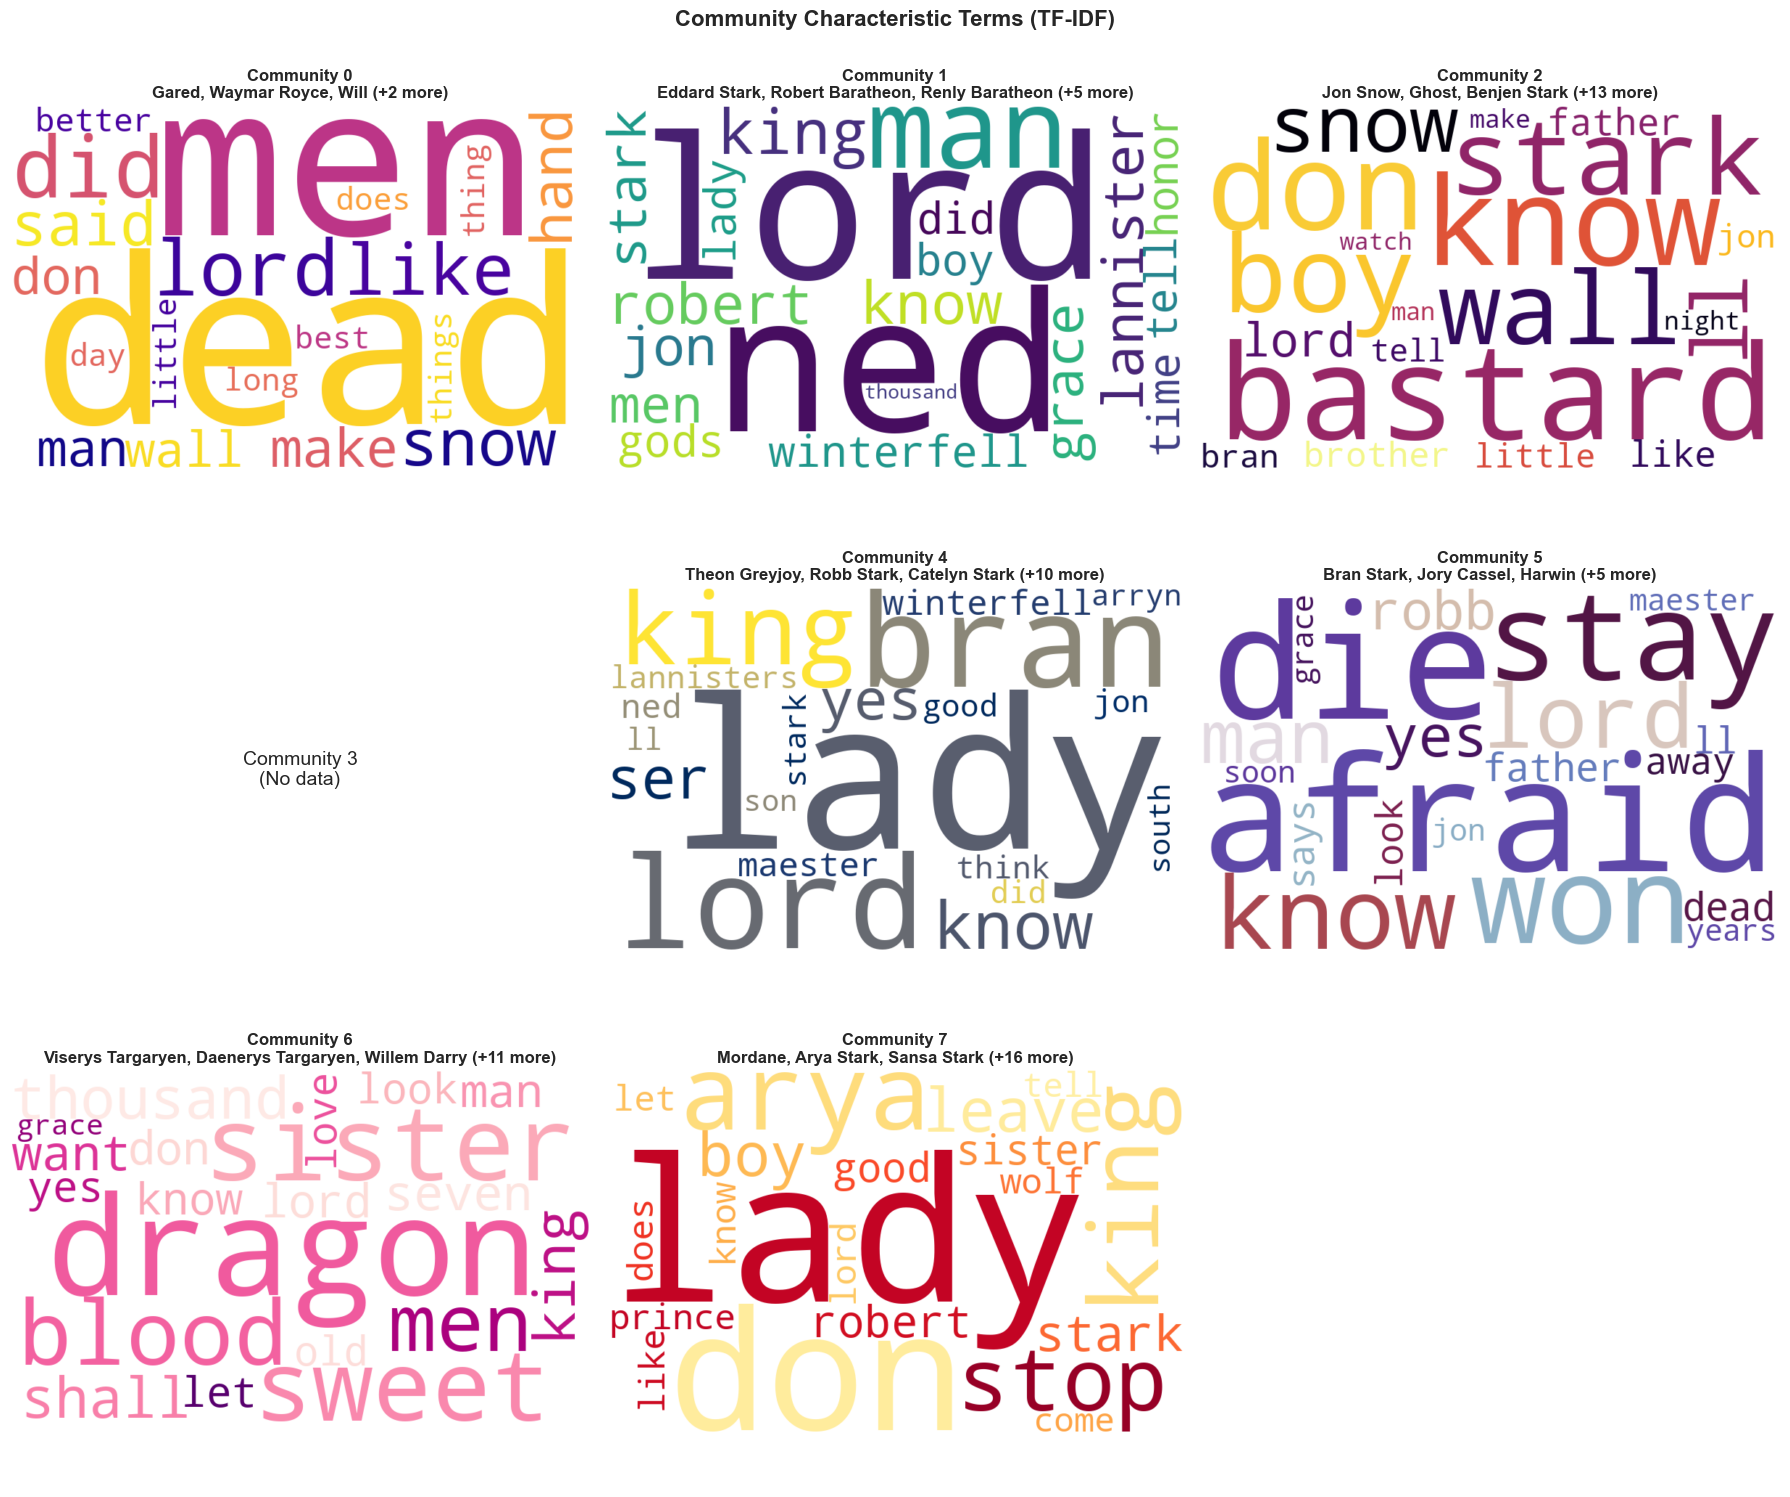

In [9]:
# 8. VISUALIZE TF-IDF WITH WORD CLOUDS

def create_community_wordclouds(community_tfidf, partition, n_cols=3):
    """
    Create word clouds for each community based on TF-IDF scores.
    """
    communities = sorted(community_tfidf.keys())
    n_communities = len(communities)
    n_rows = (n_communities + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
    
    if n_communities == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()
    
    colormaps = ['plasma', 'viridis', 'inferno', 'magma', 'cividis', 
                 'twilight_shifted', 'RdPu', 'YlOrRd']
    
    for i, comm_id in enumerate(communities):
        # Get member names for subtitle
        members = [node for node, comm in partition.items() if comm == comm_id]
        member_str = ', '.join(members[:3])
        if len(members) > 3:
            member_str += f" (+{len(members)-3} more)"
        
        # Prepare word frequencies
        tfidf_dict = {term: score for term, score in community_tfidf[comm_id]}
        
        if not tfidf_dict:
            axes[i].text(0.5, 0.5, f'Community {comm_id}\n(No data)', 
                        ha='center', va='center', fontsize=14)
            axes[i].axis('off')
            continue
        
        # Create word cloud
        wordcloud = WordCloud(
            width=800,
            height=500,
            background_color='white',
            colormap=colormaps[i % len(colormaps)],
            max_words=50,
            relative_scaling=0.5,
            collocations=False
        ).generate_from_frequencies(tfidf_dict)
        
        # Plot
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Community {comm_id}\n{member_str}', 
                         fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    # Hide empty subplots
    for j in range(n_communities, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Community Characteristic Terms (TF-IDF)', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

create_community_wordclouds(community_tfidf, partition)

In [11]:
# 9. SUMMARY STATISTICS

def print_summary_statistics(partition, modularity, G):
    """
    Print comprehensive summary statistics.
    """
    print("="*70)
    print("COMMUNITY DETECTION SUMMARY")
    print("="*70)
    
    num_communities = len(set(partition.values()))
    num_nodes = len(partition)
    
    print(f"\nAlgorithm: Louvain Method")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of communities: {num_communities}")
    print(f"Modularity (Q-score): {modularity:.4f}")
    
    # Community size statistics
    community_sizes = Counter(partition.values())
    sizes = list(community_sizes.values())
    
    print(f"\nCommunity Size Statistics:")
    print(f"  Largest community: {max(sizes)} members")
    print(f"  Smallest community: {min(sizes)} members")
    print(f"  Average community size: {np.mean(sizes):.2f} members")
    print(f"  Median community size: {np.median(sizes):.2f} members")
    
    # Interpretation guide
    print(f"\n{'='*70}")
    print("INTERPRETATION GUIDE")
    print(f"{'='*70}")
    print("Modularity Score Interpretation:")
    print("  Q > 0.3  : Strong community structure")
    print("  Q = 0.2-0.3 : Moderate community structure")
    print("  Q < 0.2  : Weak community structure")
    print(f"\nModularity: {modularity:.4f} indicates ", end="")
    if modularity > 0.3:
        print("STRONG community structure")
    elif modularity > 0.2:
        print("MODERATE community structure")
    else:
        print("WEAK community structure")

print_summary_statistics(partition, modularity, G)

COMMUNITY DETECTION SUMMARY

Algorithm: Louvain Method
Number of nodes: 85
Number of communities: 8
Modularity (Q-score): 0.5406

Community Size Statistics:
  Largest community: 19 members
  Smallest community: 2 members
  Average community size: 10.62 members
  Median community size: 10.50 members

INTERPRETATION GUIDE
Modularity Score Interpretation:
  Q > 0.3  : Strong community structure
  Q = 0.2-0.3 : Moderate community structure
  Q < 0.2  : Weak community structure

Modularity: 0.5406 indicates STRONG community structure
